#### Import


In [55]:
import pandas as pd
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.stats import pareto

#### Data

In [56]:
df = pd.read_csv('../cow_ssba.csv')
x = df['start_dates'].to_numpy().astype('float')
z = df['battle_deaths'].to_numpy().astype('float')
#x = np.append(x, 2024)
#z = np.append(z, 25000_000)

y = np.log(z)
n = len(x)

#### Functions

In [57]:
@nb.njit(nb.types.Tuple((nb.float64, nb.float64))(nb.float64[:]))
def get_xmin_a(mydata):
    xmins = np.unique(mydata) # get all unique values of data
    dat = np.zeros(len(xmins))
    z = np.sort(mydata)
    for i in range(len(xmins) - 1):
        xmin = xmins[i] # choose next xmin
        z1 = z[z >= xmin] # truncate data below this xmin value
        n = len(z1)
        a = 1 + n * np.sum(np.log(z1 / xmin))**(-1) # estimate alpha using direct MLE
        cx = (np.arange(n) + 1)[::-1] / n # construct the empirical CDF
        cf = (z1 / xmin)**(-a + 1) # construct the fitted theoretical CDF
        dat[i] = np.max(np.abs(cf - cx)) # compute the KS statistic
    
    D = np.min(dat[(dat > 0) * ~np.isnan(dat)]) # find smallest D value
    xmin = np.min(xmins[dat==D]) # find xmin value; use min in case of tie
    z = mydata[mydata >= xmin] # truncate data below xmin
    z = np.sort(z)
    n = len(z) # get tail length (in case we want to know that)
    alpha = 1 + n * np.sum(np.log(z / xmin))**(-1) # get corresponding alpha estimate via MLE
    return xmin, alpha


@nb.njit(nb.float64[:](nb.float64[:], nb.int64, nb.float64, nb.int64))
def get_permuted_sample(z, n, tau, sim):
    sample = np.zeros(sim)
    
    for s in range(sim):
        indices = np.random.permutation(n)
        zL = z[indices[:tau]]
        zR = z[indices[tau:]]
        
        xminL, alphaL = get_xmin_a(zL)
        xminR, alphaR = get_xmin_a(zR)
        
        sample[s] = alphaL - alphaR
    return sample


@nb.njit(nb.float64[:,:](nb.float64[:], nb.int64, nb.int64, nb.int64))
def get_permuted_sample_all(z, n, cutoff, sim):
    sample = np.zeros((sim, n- 2*cutoff ))
    
    for s in range(sim):
        indices = np.random.permutation(n)
        taudiff = np.zeros(n - 2 * cutoff)
        counter = 0
        for tau in range(cutoff, n - cutoff):
            zL = z[indices[:tau]]
            zR = z[indices[tau:]]
        
            xminL, alphaL = get_xmin_a(zL)
            xminR, alphaR = get_xmin_a(zR)
            
            sample[s, counter] = np.abs(alphaL - alphaR) * np.sqrt(n / tau * (n - tau))
            #sample[s, counter] = np.abs(alphaL - alphaR) 
            counter+=1
            
    
    return sample

@nb.njit(nb.float64[:,:](nb.float64[:], nb.int64, nb.int64,nb.int64, nb.int64,nb.int64, nb.int64))
def get_permuted_sample_all_specific(z, n, start, stop, sim, normalize,seed):
    np.random.seed(seed)
    sample = np.zeros((sim, stop-start ))
    
    for s in range(sim):
        indices = np.random.permutation(n)
        #taudiff = np.zeros(n - 2 * cutoff)
        counter = 0
        for tau in range(start, stop):
            zL = z[indices[:tau]]
            zR = z[indices[tau:]]
        
            xminL, alphaL = get_xmin_a(zL)
            xminR, alphaR = get_xmin_a(zR)

            if(normalize):
                sample[s, counter] = (alphaL - alphaR) * np.sqrt(n / tau * (n - tau))
            else:
                sample[s, counter] = (alphaL - alphaR)
                
            #sample[s, counter] = np.abs(alphaL - alphaR) 
            counter+=1
            
    
    return sample

#### Estimate

In [4]:
xmin, alpha = get_xmin_a(z)

#### Plot

In [5]:
logQ = np.log(np.array([np.sum(y >= y[i]) / n for i in range(n)]))

mplot = 2
ymin = np.log(xmin)
y0 = np.log(np.sum(y >= ymin) / n)
space = np.linspace(ymin, np.max(y))

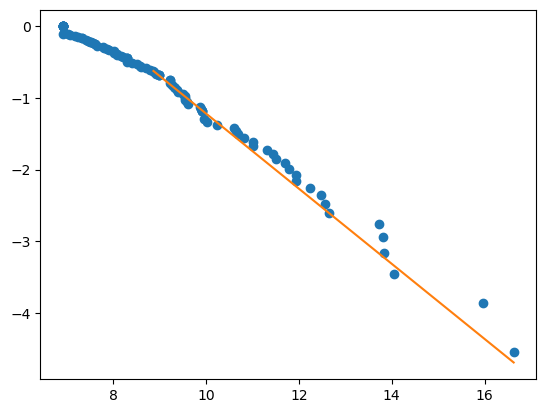

In [6]:
plt.scatter(y, logQ)
plt.plot(space, (1 - alpha) * (space - ymin) + y0, color='C1')

#### WW2

In [7]:
zL = z[x < 1945]
zR = z[x >= 1945]

yL = y[x < 1945]
yR = y[x >= 1945]

nL = len(yL)
nR = len(yR)

xminL, alphaL = get_xmin_a(zL)
xminR, alphaR = get_xmin_a(zR)

In [8]:
logQL = np.log(np.array([np.sum(yL >= yL[i]) / nL for i in range(nL)]))
logQR = np.log(np.array([np.sum(yR >= yR[i]) / nR for i in range(nR)]))

yminL = np.log(xminL)
y0L = np.log(np.sum(yL >= yminL) / nL)
spaceL = np.linspace(yminL, np.max(yL))

yminR = np.log(xminR)
y0R = np.log(np.sum(yR >= yminR) / nR)
spaceR = np.linspace(yminR, np.max(yR))

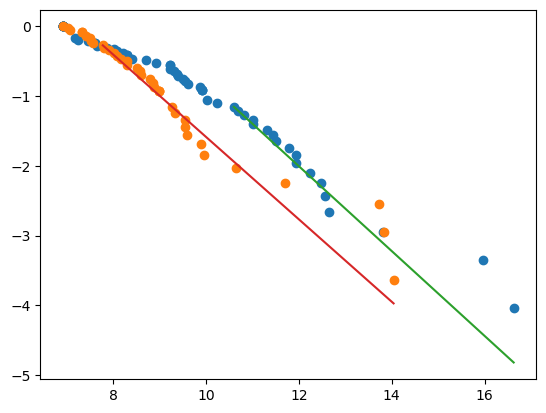

In [9]:
plt.scatter(yL, logQL)
plt.scatter(yR, logQR)
plt.plot(spaceL, (1 - alphaL) * (spaceL - yminL) + y0L, color='C2')
plt.plot(spaceR, (1 - alphaR) * (spaceR - yminR) + y0R, color='C3')
plt.show()

#### Permutation test

In [10]:
tauWW2 = np.argmax(x >= 1945)
sim = 1000

permuted_sampleWW2 = get_permuted_sample(z, n, tauWW2, sim)

In [11]:
x[70]

1969.18333333333

In [12]:
obs_diffWW2 = alphaL - alphaR
obs_diffWW2

0.01746267398489465

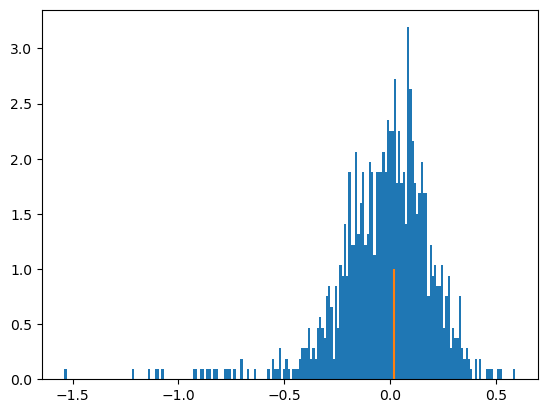

In [13]:
plt.hist(permuted_sampleWW2, bins=200, density=True)
plt.vlines(obs_diffWW2, 0, 1, color='C1')
plt.show()

In [14]:
np.quantile(permuted_sampleWW2, .95)

0.27445470845207276

#### Across all changepoints

In [15]:
cutoff =25
sim = 1000

In [16]:
sample = get_permuted_sample_all(z, n, cutoff, sim)

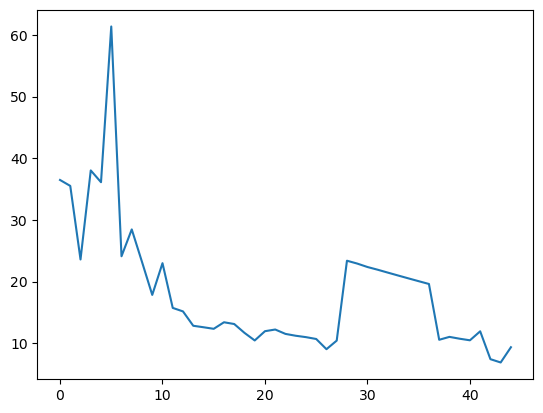

In [17]:
maxes = sample.max(axis=0)
maxes

plt.plot(maxes)

### Specific for time period 1911 - 1968

In [18]:
sim = 50000
seed = 1996
start = 38
stop = 67
print(x[start] ) #
print(x[stop]) # 1968
print(z[start])
print(z[stop])

1914.58055555556
1965.59722222222
8578031.0
7061.0


Warning: the changepoint location is defined to be the FIRST POINT in the right segment!!!!!

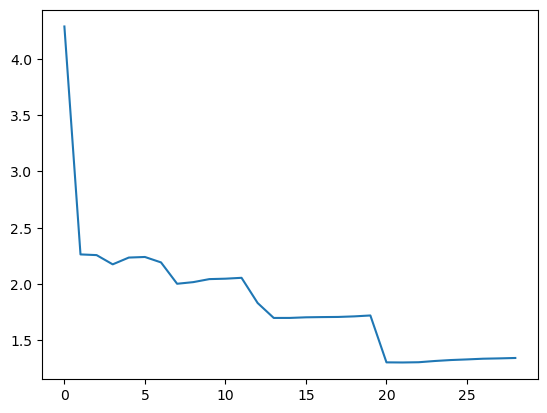

In [19]:
sample = get_permuted_sample_all_specific(z, n, start,stop, sim, normalize = 0,seed =seed)
maxes = sample.max(axis=0)
maxes

plt.plot(maxes)

#### Quantile of maximum across changepoint locations:

In [20]:
np.quantile(abs(sample), 0.99)

0.8445393142247345

#### Plot of upper 95% quantiles for each changepoint location: (two-sided)

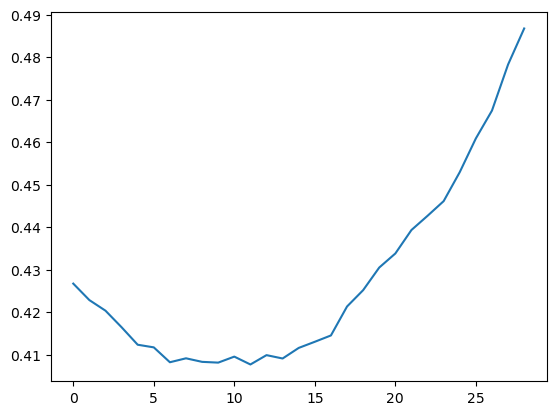

In [21]:
quantiles = np.zeros(stop - start)
for i in range(stop-start):
    quantiles[i] = np.quantile(abs(sample[:,i]),0.95)

plt.plot(quantiles)

The above plot shows that the upper quantiles ( i.e. critical values) for the test at each of the changepoint locations are of the same order and very similar. It is therefore reasonable to construct the following test: reject H_0 if the maximum statistic over the candidate changepoint locations is above a given threshold. We now find this threshold: 

In [22]:
abs_sample = np.abs(sample)
critical_value_overall_twosided = np.quantile(abs_sample.max(axis=1),0.95)
print(critical_value_overall_twosided)

0.8879648739704026


#### Multiple twosided changepoint test

In [23]:
obsdiffs = np.zeros(stop-start)
counter = 0

for tau in range(start,stop):
    zL = z[:tau]
    zR = z[tau:]
    xminL, alphaL = get_xmin_a(zL)
    xminR, alphaR = get_xmin_a(zR)
    
    obsdiffs[counter] = alphaL - alphaR
    
    counter += 1
    

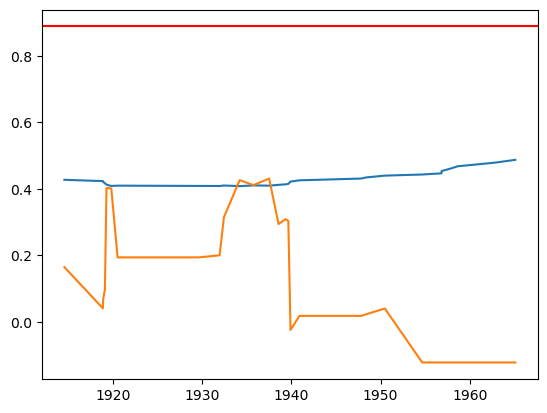

In [24]:
tauspace = np.arange(start, stop)

plt.plot(x[tauspace], quantiles)
plt.plot(x[tauspace], obsdiffs)
plt.axhline(y = critical_value_overall_twosided, color = 'r', linestyle = '-') 
#plt.plot(tauspace, 1 / (tauspace * (n - tauspace)))
#plt.plot(tauspace, np.ones(len(tauspace)) * np.quantile(sample, .95))
#plt.ylim(.3, .5)
plt.show()

#### Multiple onesided changepoint test (for a decrease in battle deaths)

Here we check the hypothesis that wars have become LESS deadly, i.e. that alpha has INCREASED, i.e alpha_R > alpha_L

In [25]:
obsdiffs_onesided_negative = np.zeros(stop-start)
counter = 0

for tau in range(start,stop):
    zL = z[:tau]
    zR = z[tau:]
    xminL, alphaL = get_xmin_a(zL)
    xminR, alphaR = get_xmin_a(zR)
    
    obsdiffs_onesided_negative[counter] = alphaR - alphaL
    
    counter += 1
    

In [26]:
onesided_negative_sample = -sample
critical_value_overall_onesided_negative = np.quantile(onesided_negative_sample.max(axis=1),0.95)
print(critical_value_overall_onesided_negative)

quantiles_onesided_negative = np.zeros(stop - start)
for i in range(stop-start):
    quantiles_onesided_negative[i] = np.quantile((-sample[:,i]),0.95)

0.7433753238090864


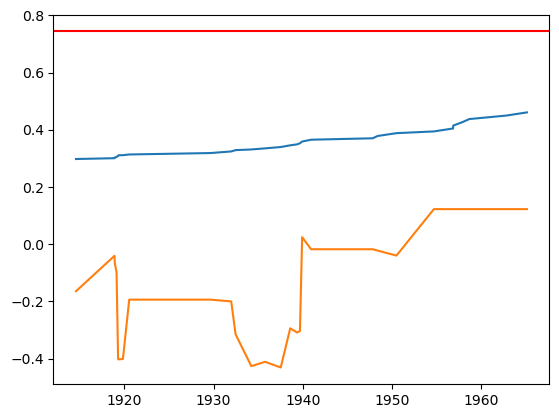

In [27]:
tauspace = np.arange(start, stop)

plt.plot(x[tauspace], quantiles_onesided_negative)
plt.plot(x[tauspace], obsdiffs_onesided_negative)
plt.axhline(y = critical_value_overall_onesided_negative, color = 'r', linestyle = '-') 
#plt.plot(tauspace, 1 / (tauspace * (n - tauspace)))
#plt.plot(tauspace, np.ones(len(tauspace)) * np.quantile(sample, .95))
#plt.ylim(.3, .5)
plt.show()

#### Multiple onesided changepoint test (for an increase in battle deaths)

Here we check the hypothesis that wars have become MORE deadly, i.e. that alpha has DECREASED, i.e alpha_L > alpha_R

In [28]:
obsdiffs_onesided_positive = np.zeros(stop-start)
counter = 0

for tau in range(start,stop):
    zL = z[:tau]
    zR = z[tau:]
    xminL, alphaL = get_xmin_a(zL)
    xminR, alphaR = get_xmin_a(zR)
    
    obsdiffs_onesided_positive[counter] = alphaL - alphaR
    
    counter += 1
    

In [29]:
critical_value_overall_onesided_positive = np.quantile(sample.max(axis=1),0.95)
print(critical_value_overall_onesided_positive)

quantiles_onesided_positive = np.zeros(stop - start)
for i in range(stop-start):
    quantiles_onesided_positive[i] = np.quantile((sample[:,i]),0.95)

0.5537857352040204


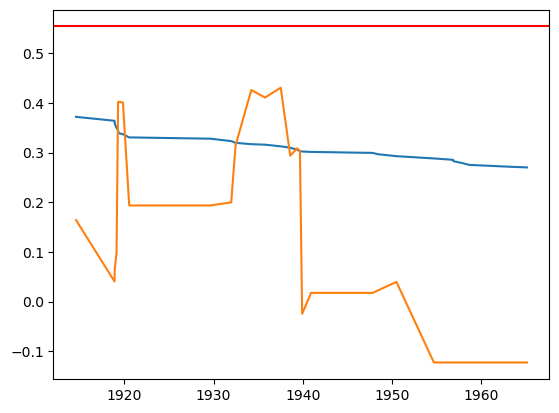

In [30]:
tauspace = np.arange(start, stop)

plt.plot(x[tauspace], quantiles_onesided_positive)
plt.plot(x[tauspace], obsdiffs_onesided_positive)
plt.axhline(y = critical_value_overall_onesided_positive, color = 'r', linestyle = '-') 
#plt.plot(tauspace, 1 / (tauspace * (n - tauspace)))
#plt.plot(tauspace, np.ones(len(tauspace)) * np.quantile(sample, .95))
#plt.ylim(.3, .5)
plt.show()

In [31]:
p_val_onesided_positive = np.sum(sample.max(axis=1) > np.max(obsdiffs_onesided_positive)) / sim
print(p_val_onesided_positive)

0.09292


#### World war two

In [32]:
tauWW2

57

In [33]:
tau = tauWW2+1 # the changepoint location is implicitly defined as the first observation in the new segment
zL = z[:tau]
zR = z[tau:]
xminL, alphaL = get_xmin_a(zL)
xminR, alphaR = get_xmin_a(zR)

print(alphaL)
print(alphaR)

1.6079519125661128
1.5858207347417657


# Including Ukraine

In [107]:
xu = df['start_dates'].to_numpy().astype('float')
zu = df['battle_deaths'].to_numpy().astype('float')

xu = np.append(x, 2024)
zu = np.append(zu, 3_500_000)

yu = np.log(zu)
nu = len(xu)

In [108]:
nu

96

In [109]:
sim = 50000
seed = 1996
start = 38
stop = 67
print(x[start] ) #
print(x[stop]) # 1968
print(z[start])
print(z[stop])

1914.58055555556
1965.59722222222
8578031.0
7061.0


Warning: the changepoint location is defined to be the FIRST POINT in the right segment!!!!!

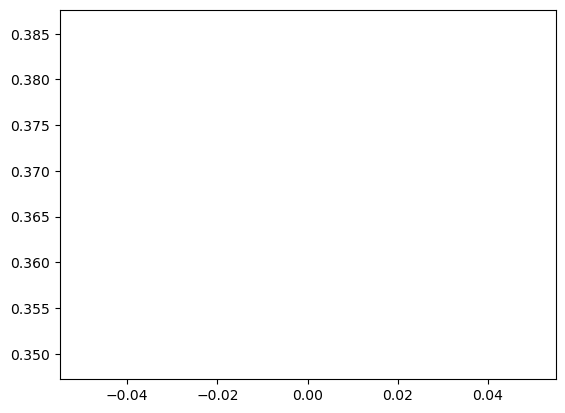

In [110]:
sampleu = get_permuted_sample_all_specific(zu, nu, start,stop, sim, normalize = 0,seed =seed)
maxesu = sampleu.max(axis=0)
maxesu

plt.plot(maxesu)

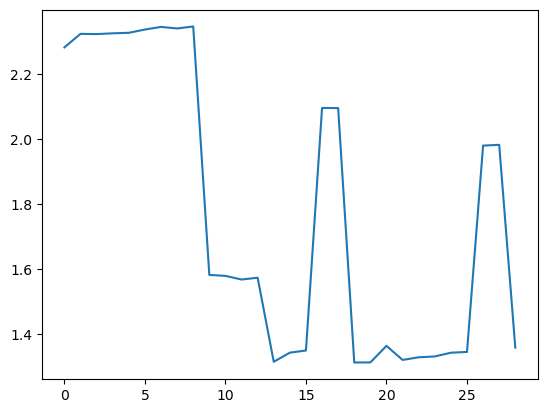

In [125]:
maxesu = sampleu.max(axis=0)
plt.plot(maxesu)

#### Quantile of maximum across changepoint locations:

In [111]:
np.quantile(abs(sampleu), 0.99)

0.69160817018019

#### Plot of upper 95% quantiles for each changepoint location: (two-sided)

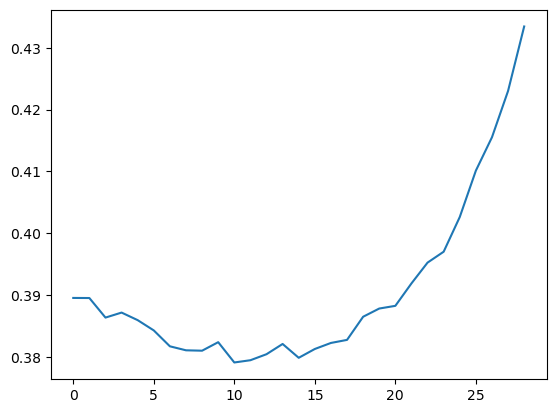

In [112]:
quantilesu = np.zeros(stop - start)
for i in range(stop-start):
    quantilesu[i] = np.quantile(abs(sampleu[:,i]),0.95)

plt.plot(quantilesu)

The above plot shows that the upper quantiles ( i.e. critical values) for the test at each of the changepoint locations are of the same order and very similar. It is therefore reasonable to construct the following test: reject H_0 if the maximum statistic over the candidate changepoint locations is above a given threshold. We now find this threshold: 

In [113]:
abs_sampleu = np.abs(sampleu)
critical_value_overall_twosidedu = np.quantile(abs_sampleu.max(axis=1),0.95)
print(critical_value_overall_twosidedu)

0.7496681473294395


#### Multiple twosided changepoint test

In [114]:
obsdiffsu = np.zeros(stop-start)
counter = 0

for tau in range(start,stop):
    zL = zu[:tau]
    zR = zu[tau:]
    xminL, alphaL = get_xmin_a(zL)
    xminR, alphaR = get_xmin_a(zR)
    
    obsdiffsu[counter] = alphaL - alphaR
    
    counter += 1
    

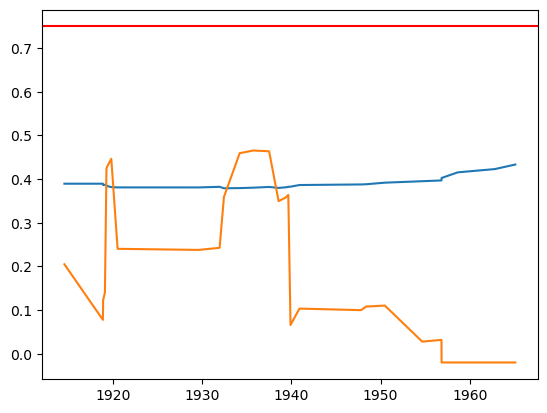

In [115]:
tauspace = np.arange(start, stop)

plt.plot(xu[tauspace], quantilesu)
plt.plot(xu[tauspace], obsdiffsu)
plt.axhline(y = critical_value_overall_twosidedu, color = 'r', linestyle = '-') 
#plt.plot(tauspace, 1 / (tauspace * (n - tauspace)))
#plt.plot(tauspace, np.ones(len(tauspace)) * np.quantile(sample, .95))
#plt.ylim(.3, .5)
plt.show()

#### Multiple onesided changepoint test (for a decrease in battle deaths)

Here we check the hypothesis that wars have become LESS deadly, i.e. that alpha has INCREASED, i.e alpha_R > alpha_L

In [116]:
obsdiffs_onesided_negativeu = np.zeros(stop-start)
counter = 0

for tau in range(start,stop):
    zL = zu[:tau]
    zR = zu[tau:]
    xminL, alphaL = get_xmin_a(zL)
    xminR, alphaR = get_xmin_a(zR)
    
    obsdiffs_onesided_negativeu[counter] = alphaR - alphaL
    
    counter += 1
    

In [117]:
onesided_negative_sampleu = -sampleu
critical_value_overall_onesided_negativeu = np.quantile(onesided_negative_sampleu.max(axis=1),0.95)
print(critical_value_overall_onesided_negativeu)

quantiles_onesided_negativeu = np.zeros(stop - start)
for i in range(stop-start):
    quantiles_onesided_negativeu[i] = np.quantile((-sampleu[:,i]),0.95)

0.614108105296688


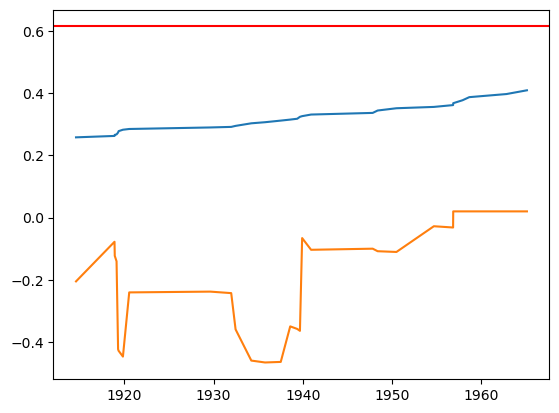

In [118]:
tauspace = np.arange(start, stop)

plt.plot(xu[tauspace], quantiles_onesided_negativeu)
plt.plot(xu[tauspace], obsdiffs_onesided_negativeu)
plt.axhline(y = critical_value_overall_onesided_negativeu, color = 'r', linestyle = '-') 
#plt.plot(tauspace, 1 / (tauspace * (n - tauspace)))
#plt.plot(tauspace, np.ones(len(tauspace)) * np.quantile(sample, .95))
#plt.ylim(.3, .5)
plt.show()

#### Multiple onesided changepoint test (for an increase in battle deaths)

Here we check the hypothesis that wars have become MORE deadly, i.e. that alpha has DECREASED, i.e alpha_L > alpha_R

In [119]:
obsdiffs_onesided_positiveu = np.zeros(stop-start)
counter = 0

for tau in range(start,stop):
    zL = zu[:tau]
    zR = zu[tau:]
    xminL, alphaL = get_xmin_a(zL)
    xminR, alphaR = get_xmin_a(zR)
    
    obsdiffs_onesided_positiveu[counter] = alphaL - alphaR
    
    counter += 1
    

In [120]:
critical_value_overall_onesided_positiveu = np.quantile(sampleu.max(axis=1),0.95)
print(critical_value_overall_onesided_positiveu)

quantiles_onesided_positiveu = np.zeros(stop - start)
for i in range(stop-start):
    quantiles_onesided_positiveu[i] = np.quantile((sampleu[:,i]),0.95)

0.4969138486894023


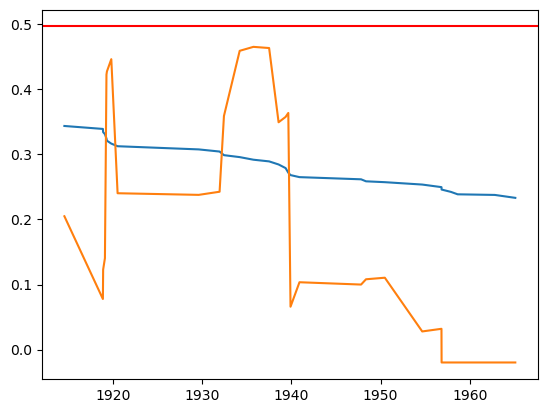

In [126]:
tauspace = np.arange(start, stop)

plt.plot(xu[tauspace], quantiles_onesided_positiveu)
plt.plot(xu[tauspace], obsdiffs_onesided_positiveu)
plt.axhline(y = critical_value_overall_onesided_positiveu, color = 'r', linestyle = '-') 
#plt.plot(tauspace, 1 / (tauspace * (n - tauspace)))
#plt.plot(tauspace, np.ones(len(tauspace)) * np.quantile(sample, .95))
#plt.ylim(.3, .5)
plt.show()

Actually there is some evidence of an increase..... just before the second world war..

In [122]:
p_val_onesided_positiveu = np.sum(sampleu.max(axis=1) > np.max(obsdiffs_onesided_positiveu)) / sim
print(p_val_onesided_positiveu)

0.05942


#### World war two

In [77]:
obsdiffs_onesided_positiveu

array([ 0.16444708,  0.02757588,  0.07714294,  0.09984522,  0.39087909,
        0.41311549,  0.4080992 ,  0.2053096 ,  0.2053096 ,  0.20784904,
        0.32690096,  0.41537173,  0.4237937 ,  0.44272222,  0.31008861,
        0.30266203,  0.31943698,  0.01561129,  0.03383839,  0.03383839,
        0.03133637,  0.06887687, -0.07082445, -0.07082445, -0.07082445,
       -0.07082445, -0.07082445, -0.07082445, -0.07082445])

In [49]:
tauWW2

57

In [90]:
tau = tauWW2-4 # the changepoint location is implicitly defined as the first observation in the new segment
zL = zu[:tau]
zR = zu[tau:]
xminL, alphaL = get_xmin_a(zL)
xminR, alphaR = get_xmin_a(zR)

print(alphaL)
print(alphaR)
print(alphaL - alphaR)

1.7806971222225962
1.4780350893232752
0.30266203289932103


# OTHER STUFF:

In [51]:
obsdiffs = np.zeros(n - 2 * cutoff)
counter = 0

for tau in range(cutoff, n - cutoff):
    zL = z[:tau]
    zR = z[tau:]
    xminL, alphaL = get_xmin_a(zL)
    xminR, alphaR = get_xmin_a(zR)
    
    obsdiffs[counter] = np.sqrt(tau * (n - tau)) * np.abs(alphaL - alphaR)
    
    counter += 1
    

In [52]:
np.max(obsdiffs)

20.394984017279914

In [53]:
sim = 1000
cutoff = 5

quantiles = np.zeros(n - 2*cutoff)
counter = 0

for tau in range(cutoff, n - cutoff):
    sample = get_permuted_sample(z, n, tau, sim)
    quantiles[counter] = np.quantile(sample, .95)
    
    
    counter += 1

ValueError: x and y must have same first dimension, but have shapes (85,) and (45,)

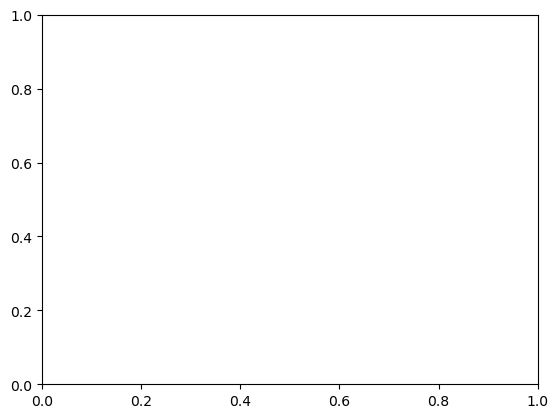

In [54]:
tauspace = np.arange(cutoff, n - cutoff)

#plt.plot(tauspace, quantiles)
plt.plot(tauspace, obsdiffs)
#plt.plot(tauspace, 1 / (tauspace * (n - tauspace)))
plt.plot(tauspace, np.ones(len(tauspace)) * np.quantile(sample, .95))
plt.show()

#### Check power

In [ ]:
n = 150
cutoff = 5
n1 = n // 2
n2 = n - n1

z1 = pareto(b=2.2).rvs(n1)
z2 = pareto(b=1.8).rvs(n2)

z = np.concatenate((z1, z2))

In [ ]:
sample = get_permuted_sample_all(z, n, cutoff, sim)

In [ ]:
np.quantile(sample, .95)

In [ ]:
obsdiffs = np.zeros(n - 2 * cutoff)
counter = 0

for tau in range(cutoff, n - cutoff):
    zL = z[:tau]
    zR = z[tau:]
    xminL, alphaL = get_xmin_a(zL)
    xminR, alphaR = get_xmin_a(zR)
    
    obsdiffs[counter] = np.sqrt(tau * (n - tau)) * np.abs(alphaL - alphaR)
    
    counter += 1

In [ ]:
tauspace = np.arange(cutoff, n - cutoff)

In [ ]:
plt.plot(tauspace, obsdiffs)

#### Korea only

In [ ]:
zL = z[x < 1950]
zR = z[x >= 1950]

yL = y[x < 1950]
yR = y[x >= 1950]

nL = len(yL)
nR = len(yR)

xminL, alphaL = get_xmin_a(zL)
xminR, alphaR = get_xmin_a(zR)

In [ ]:
logQL = np.log(np.array([np.sum(yL >= yL[i]) / nL for i in range(nL)]))
logQR = np.log(np.array([np.sum(yR >= yR[i]) / nR for i in range(nR)]))

yminL = np.log(xminL)
y0L = np.log(np.sum(yL >= yminL) / nL)
spaceL = np.linspace(yminL, np.max(yL))

yminR = np.log(xminR)
y0R = np.log(np.sum(yR >= yminR) / nR)
spaceR = np.linspace(yminR, np.max(yR))

In [ ]:
obs_diffK = np.abs(alphaL - alphaR)
obs_diffK

In [ ]:
tauK = np.argmax(x >= 1950)
sim = 10_000

permuted_sampleK = get_permuted_sample(z, n, tauK, sim)

In [ ]:
np.quantile(permuted_sampleK, .95)

#### Pointwise p-values

In [ ]:
sim = 1000
cutoff = 5

quantiles1 = np.zeros(n - 2*cutoff)
quantiles2 = np.zeros(n - 2*cutoff)
counter = 0

for tau in range(cutoff, n - cutoff):
    sample = get_permuted_sample(z, n, tau, sim)
    quantiles1[counter] = np.quantile(sample, .95)
    
    
    counter += 1

In [ ]:
obsdiffs = np.zeros(n - 2 * cutoff)
counter = 0

for tau in range(cutoff, n - cutoff):
    zL = z[:tau]
    zR = z[tau:]
    xminL, alphaL = get_xmin_a(zL)
    xminR, alphaR = get_xmin_a(zR)
    
    obsdiffs[counter] = alphaL - alphaR
    
    counter += 1
    

In [ ]:
tauspace = np.arange(cutoff, n - cutoff)

plt.plot(tauspace, quantiles)
plt.plot(tauspace, obsdiffs)
#plt.plot(tauspace, 1 / (tauspace * (n - tauspace)))
#plt.plot(tauspace, np.ones(len(tauspace)) * np.quantile(sample, .95))
#plt.ylim(.3, .5)
plt.show()